In [2]:
#add ../ to the path
import sys
sys.path.append("../")
import numpy as np
import pynbody
from SimInfoDicts.MerianCDM import Sims
#from SimInfoDicts.BWMDC import Sims
sim = Sims['r431']
s = pynbody.load(sim['path'])
s.physical_units()
h = s.halos()

In [3]:
halo = h[1]
pynbody.analysis.angmom.faceon(halo)

In [72]:
from pynbody.analysis.interpolate import interpolate2d
_cmd_lum_file = '/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/pynbody/analysis/cmdlum.npz'
def calc_mags(simstars, band='v', cmd_path=None):
    """Calculating visible magnitudes

    Using Padova Simple stellar populations (SSPs) from Girardi
    http://stev.oapd.inaf.it/cgi-bin/cmd
    Marigo+ (2008), Girardi+ (2010)

    pynbody includes a grid of SSP luminosities for many bandpasses for
    various stellar ages and metallicities.  This function linearly
    interpolates to the desired value and returns the value as a magnitude.

    **Usage:**


    **Optional keyword arguments:**

       *band* (default='v'): Which observed bandpass magnitude in which
            magnitude should be calculated

       *path* (default=None): Path to the CMD grid. If None, use the
            default or a path specified by use_custom_cmd. For more information
            about generating a custom CMD grid, see use_custom_cmd.

    """

    # find data file in PYTHONPATH
    # data is from http://stev.oapd.inaf.it/cgi-bin/cmd
    # Padova group stellar populations Marigo et al (2008), Girardi et al
    # (2010)
    if cmd_path is not None:
        lums = np.load(cmd_path)
    else:
        lums = np.load(_cmd_lum_file)


    age_star = simstars['age'].in_units('yr')
    # allocate temporary metals that we can play with
    metals = simstars['metals']
    # get values off grid to minmax
    age_star[np.where(age_star < np.min(lums['ages']))] = np.min(lums['ages'])
    age_star[np.where(age_star > np.max(lums['ages']))] = np.max(lums['ages'])
    metals[np.where(metals < np.min(lums['mets']))] = np.min(lums['mets'])
    metals[np.where(metals > np.max(lums['mets']))] = np.max(lums['mets'])
    
    #print range of data, and range of grid 
    
    print(np.min(age_star),np.max(age_star))
    print(np.min(lums['ages']),np.max(lums['ages']))
    print(np.min(metals),np.max(metals))
    print(np.min(lums['mets']),np.max(lums['mets']))
    

    age_grid = np.log10(lums['ages'])
    met_grid = lums['mets']
    mag_grid = lums[band]
    
    
    from scipy.interpolate import interpn

    points = (met_grid, age_grid)
    output_mags = interpn(points, mag_grid, np.column_stack((metals, age_star)) , bounds_error=False, fill_value=None)
    


    print(metals.shape, np.log10(age_star).shape, met_grid.shape, age_grid.shape, mag_grid.shape)
    
    #output_mags = interpolate2d(
    #    metals, np.log10(age_star), met_grid, age_grid, mag_grid)

    try:
        vals = output_mags - 2.5 * \
            np.log10(simstars['massform'].in_units('Msol'))
    except KeyError:
        vals = output_mags - 2.5 * np.log10(simstars['mass'].in_units('Msol'))

    #vals.units = None
    return vals

In [94]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.cosmology import FlatLambdaCDM
from pynbody.array import SimArray
@pynbody.derived_array
def v_lum(halo):
    L = 10**((4.77 - halo.s['v_mag']) / 2.5) * 3.828e33  # in W
    return SimArray(L, "erg s**-1")
    return L


def generate_base_image(halo,pixel_scale,distance):
    # Calculate the half-light radius
    Rhalf = pynbody.analysis.luminosity.half_light_r(halo)
    width = 6 * Rhalf
    
    #make sure other necassray arrays are loaded
    halo.s['v_mag']
    #age
    halo.s['age']
    #metallicity
    halo.s['metals']
    
    
    #calculate magnitues for each star
    calc_mags(halo.s)
    
    
    #calculate luminosities for each star
    print(halo.s['v_lum'])
    
    #print sum of luminosities for the galaxy
    lum_total = np.sum(halo.s['v_lum'])
    print(f'Total luminosity of the galaxy: {lum_total:.2e}')
    

    # Calculate the resolution of the image from angular size and pixel scale
    angular_size = width*1e3 / distance  * 180 / np.pi * 3600  # arcsec
    print(width,width.units)
    print(angular_size)
    res = int(angular_size / pixel_scale)
    print(res)
    #sanity check, keep resolution above 100, below 1000
    if res < 100:
        res = 100
    if res > 1000:
        res = 1000
    print(res)
    
    # Define the image space
    ImageSpace = pynbody.filt.Sphere(width * np.sqrt(2) * 1.01)
    
    # Set up the figure
    f = plt.figure(frameon=False)
    f.set_size_inches(10, 10)
    ax = plt.Axes(f, [0., 0., 1., 1.])
    ax.set_axis_off()
    f.add_axes(ax)
    
    # Generate V-band surface brightness image
    im = pynbody.plot.sph.image(halo[ImageSpace].s, qty='v_lum', width=width, 
                                subplot=ax, resolution=res,
                                show_cbar=False, noplot=False)
    #im = pynbody.plot.stars.render(halo,width=width, resolution=res,plot=True,ret_im=True)
    #convert width to physical units
    return im

from pynbody.plot.stars import render



from scipy.ndimage import zoom




3980000.0 14095756535.653246
3980000.0 14100000000.0
0.0001 0.03
0.0001 0.03
(2292901,) (2292901,) (22,) (72,) (22, 72)
[1.87936694e+09 1.88205270e+09 1.88227677e+09 ... 2.95696253e+11
 2.81690233e+11 2.80440910e+11]
Total luminosity of the galaxy: 8.69e+15
25.20500173960123 kpc
5198.904800276575
103978
1000


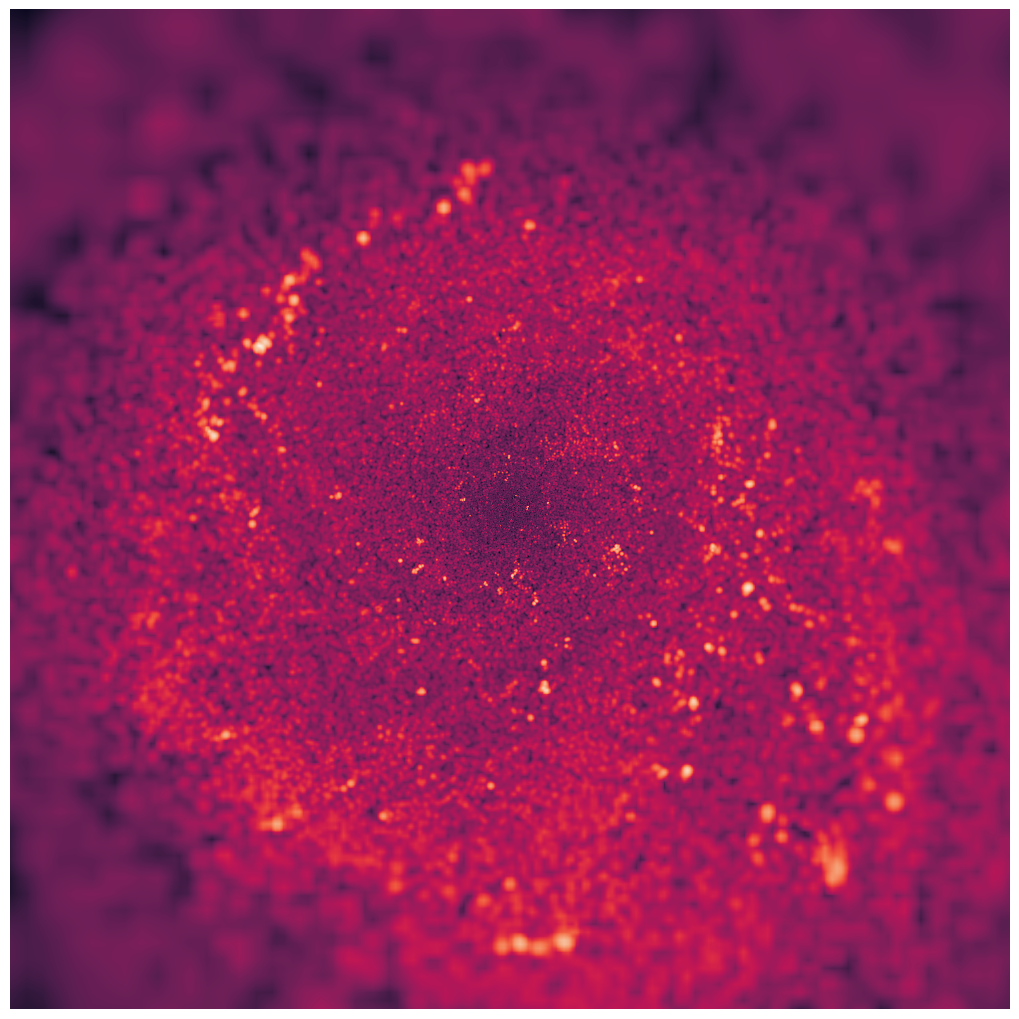

In [95]:
# Usage
distance = 1e6 # distance in parsecs
exposure_time = 1000 # exposure time in seconds
pixel_scale = 0.05  # HST WFC3 UVIS pixel scale in arcseconds/pixel

# calculate the resolution of the image from angular size and pixel scale


# Generate base image
base_image = generate_base_image(halo,pixel_scale,distance)

In [97]:
#total luminosity of the galaxy by summing the luminosities of all the pixels
lum_total = np.sum(base_image)
print(f'Total luminosity of the galaxy: {lum_total:.2e}')


Total luminosity of the galaxy: 4.27e+15


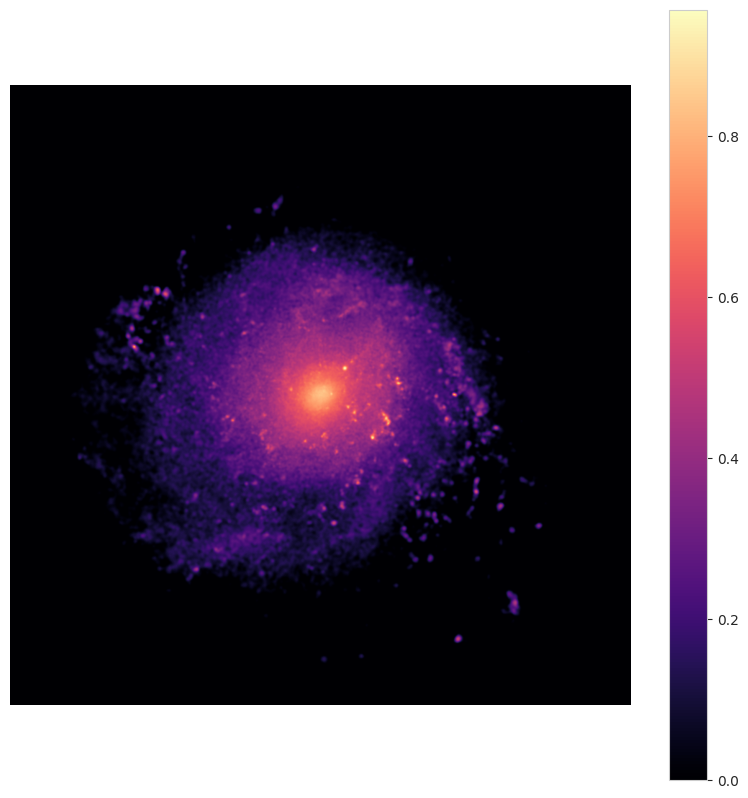

In [20]:
def simulate_instrument_view(im, distance, exposure_time, pixel_scale):
    # Set up cosmology
    #only about worry about cosmology if distance is greate than 10 Mpc
    if distance > 1e7:
        
        cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


        d = astropy.units.Quantity(distance, unit='pc')
        redshift = d.to(cu.redshift, cu.redshift_distance(cosmo, kind="comoving", zmax=10))

        # Apply cosmological dimming
        im /= (1 + redshift)**2
    

    


    # Convolve with HST PSF (simplified Gaussian approximation)
    # PSF FWHM is 0.13 arcsec for WFC3 UVIS
    psf_fwhm = 0.13
    psf_sigma = psf_fwhm / 2.355
    #psf_kernel = Gaussian2DKernel(psf_sigma / pixel_scale)
    kernel = Gaussian2DKernel(x_stddev=psf_sigma / pixel_scale)
    im_convolved = convolve(im, kernel)
    
    # Apply Poisson noise
    im_noisy = np.random.poisson(im_convolved * exposure_time)
    
    im_final = im_convolved + im_noisy


    
    return im_final

 # physical size of the image in kpc

# Simulate instrument view

#get 1 of the 3 color channels
image = base_image[:,:,0]

simulated_image = simulate_instrument_view(image, distance, exposure_time, pixel_scale)

# Plot the result
plt.figure(figsize=(10, 10))
plt.imshow(simulated_image, origin='lower', cmap='magma')
plt.colorbar()
plt.axis('off')
plt.grid(False)
plt.show()


